In [ ]:
from src.data.graph_analyzer import GraphAnalyzer


In [1]:
from graph_tool.all import load_graph

file_path = 'data/processed/wikipedia_Amiga_CD32_games.gml'
# file_path = 'data/processed/graph_jazz_collab.gml'

G = load_graph(file_path, fmt='gml')


In [2]:
num_nodes = G.num_vertices()

# Total number of edges
num_edges = G.num_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 88890
Number of edges: 8048021


In [3]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
import math
from tqdm import tqdm
from graph_tool.correlations import scalar_assortativity
from graph_tool.generation import random_rewire
import graph_tool as gt
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from graph_tool.centrality import closeness, betweenness, eigenvector
import time


class GraphToolAnalyzer:
    def __init__(self, graph):
        self.graph = graph
        self.randomized_graph = None
        self.measures = ['degrees','closeness', 'betweenness', 'eigenvector']
        self.centrality = {}



    def get_degree_and_average_degree_of_neighbors(self, G=None):
        if G is None:
            G = self.graph

        degrees, average_degrees = [], []

        degree_map = G.degree_property_map("total")
        total_vertices = G.num_vertices()

        for v in tqdm(G.vertices(), total=total_vertices, desc="Processing vertices", unit="vertex"):
            neighbors = v.all_neighbors()

            sum_degrees = 0
            neighbor_count = 0

            for neighbor in neighbors:
                sum_degrees += degree_map[neighbor]
                neighbor_count += 1

            current_node_degree = degree_map[v]
            average_degree = sum_degrees / neighbor_count if neighbor_count > 0 else 0

            degrees.append(current_node_degree)
            average_degrees.append(average_degree)

        degree_dict = defaultdict(lambda: {'sum': 0, 'count': 0})

        for degree, avg_degree in zip(degrees, average_degrees):
            degree_dict[degree]['sum'] += avg_degree
            degree_dict[degree]['count'] += 1

        unique_degrees = []
        averaged_average_degrees = []

        for degree, values in degree_dict.items():
            unique_degrees.append(degree)
            averaged_average_degrees.append(values['sum'] / values['count'])

        return unique_degrees, averaged_average_degrees

    def plot_degree_vs_avg_degree(self, title, plot_randomized=False):
        x, y = self.get_degree_and_average_degree_of_neighbors()
        assortativity_real_network = self.calculate_assortativity()

        color = 'blue'
        label_real_network = f'Real network (assortativity: {assortativity_real_network:.3g})'
        data = [(x, y, color, label_real_network)]

        if plot_randomized:
            self.randomize_graph()

            x, y = self.get_degree_and_average_degree_of_neighbors(self.randomized_graph)
            assortativity_randomized_network = self.calculate_assortativity(self.randomized_graph)

            color = 'red'
            label_randomized_network = f'Randomized network (assortativity: {assortativity_randomized_network:.3g})'
            data.append((x, y, color, label_randomized_network))

        fig, ax = plt.subplots()
        for data_set in data:
            x, y, color, label = data_set
            ax.scatter(x, y, c=color, label=label, alpha=0.7)

        ax.legend()
        plt.xlabel('Degree')
        plt.ylabel('Average degree of neighbors')
        plt.title(title)
        plt.show()

    def randomize_graph(self, force_randomization=False):
        if self.randomized_graph is None or force_randomization:
            self.randomized_graph = self.graph.copy()
            random_rewire(self.randomized_graph, 
                    model="configuration",
                    n_iter=3)



    def calculate_assortativity(self, G=None):
        if G is None:
            G = self.graph

        degree_map = G.degree_property_map("total")
        assortativity, _ = scalar_assortativity(G, degree_map)
        return assortativity

    def plot_log_log_probability_density(self, title):
        G = self.graph
        
        # Get degrees using graph-tool's degree property map
        degrees = G.get_total_degrees(G.get_vertices())
        
        # Create logarithmic bins
        logarithmic_bins = np.logspace(np.log10(max(1, min(degrees))), 
                                    np.log10(max(degrees)), 
                                    num=20)
        
        # Create histogram
        plt.hist(degrees, bins=logarithmic_bins, density=True)
        
        # Set scales and labels
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Degree (k)')
        plt.ylabel('Probability Density p(k)')
        plt.title(title)
        plt.grid(True)
        plt.show()

    def calculate_centralities(self, is_randomized=False, num_threads=4):
        # Enable parallel execution
        openmp_set_num_threads(num_threads)
        
        if is_randomized:
            G = self.randomized_graph
            suffix = '_randomized'
        else:
            G = self.graph
            suffix = ''
        
        try:
            print("Calculating degrees...")
            start_time = time.time()
            self.centrality[f'degrees{suffix}'] = G.get_total_degrees(G.get_vertices())
            print(f"Degrees calculated in {time.time() - start_time:.2f} seconds.\n")

            print("Calculating eigenvector...")
            start_time = time.time()
            eig = eigenvector(G, max_iter=100, epsilon=1e-6)
            self.centrality[f'eigenvector{suffix}'] = eig[1].get_array()
            print(f"Eigenvector centrality calculated in {time.time() - start_time:.2f} seconds.\n")


            print("Calculating closeness...")
            start_time = time.time()
            close = closeness(G)
            self.centrality[f'closeness{suffix}'] = close.get_array()
            print(f"Closeness centrality calculated in {time.time() - start_time:.2f} seconds.\n")


            print("Calculating betweenness...")
            start_time = time.time()
            vbet, _ = betweenness(G, norm=True)
            self.centrality[f'betweenness{suffix}'] = vbet.get_array()
            print(f"Betweenness centrality calculated in {time.time() - start_time:.2f} seconds.\n")

        
        except Exception as e:
            print(f"Error calculating centralities: {e}")
            raise

        
    def calculate_centralities2(self, is_randomized=False):
        from graph_tool.centrality import closeness, betweenness, eigenvector
        
        if is_randomized:
            G = self.randomized_graph
            suffix = '_randomized'
        else:
            G = self.graph
            suffix = ''
        
        try:
            # Degrees
            self.centrality[f'degrees{suffix}'] = G.get_total_degrees(G.get_vertices())
            
            # Closeness
            close = closeness(G)
            self.centrality[f'closeness{suffix}'] = close.get_array()
            
            # Betweenness
            vbet, _ = betweenness(G, norm=True)
            self.centrality[f'betweenness{suffix}'] = vbet.get_array()
            
            # Eigenvector
            eig = eigenvector(G)
            self.centrality[f'eigenvector{suffix}'] = eig[1].get_array()
            
        except Exception as e:
            print(f"Error calculating centralities: {e}")
            raise

    def plot_log_log_centrality_distribution(self, centralities, logarithmic_bins, x_label='not defined', y_label='Probability Density'): 

        plt.hist(centralities, bins=logarithmic_bins, density=True)
        # plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title('Title')
        plt.show()

    def plot_centralities(self):
        self.calculate_centralities()

        for measure in self.measures:
            linear_bins = np.linspace(min(self.centrality[measure]), max(self.centrality[measure]), num=16)
            self.plot_log_log_centrality_distribution(self.centrality[measure], linear_bins, measure, 'TBD')


    def plot_centralities_comparison(self):

        self.calculate_centralities()

        measure_pairs = [(x, y) for x in self.measures for y in self.measures if x != y]
        for pair in measure_pairs:
            if (pair[1], pair[0]) in measure_pairs:
                measure_pairs.remove((pair[1], pair[0]))

        data_structure = []
        for measure_pair in measure_pairs:

            data_structure.append([(self.centrality[measure_pair[0]], self.centrality[measure_pair[1]], 'blue',
                                f"{measure_pair[0]} vs {measure_pair[1]}", measure_pair[0], measure_pair[1], 'Title')])

        self.plot_centrality_measure_vs_centrality_measure(
            data_structure, f"{measure_pair[0]} vs {measure_pair[1]}", show_legend=False)
    

  
    def plot_centrality_measure_vs_centrality_measure(self, data, overall_title, show_legend=True):
        n_plots = len(data)

        n_cols = min(3, math.ceil(math.sqrt(n_plots)))  
        n_rows = math.ceil(n_plots / n_cols)

        fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

        if n_rows == 1 and n_cols == 1:
            ax = [ax]
        else:
            ax = ax.flatten()

        for i in range(n_plots):
            corr_text = ""
            for data_point in data[i]:
                x, y, color, label, x_label, y_label, title = data_point
                pearson_corr, _ = pearsonr(x, y)
                spearman_corr, _ = spearmanr(x, y)
                kendall_corr, _ = kendalltau(x, y)
                corr_text += (
                    f"Pearson: {pearson_corr:.2f}\n"
                    f"Spearman: {spearman_corr:.2f}\n"
                    f"Kendall: {kendall_corr:.2f}"
                )
                ax[i].scatter(x, y, c=color, label=label, alpha=0.7)

            ax[i].text(0.05, 0.95, corr_text, transform=ax[i].transAxes,
                    fontsize=8, verticalalignment='top')
            if show_legend:
                ax[i].legend()
            ax[i].set_xlabel(x_label)
            ax[i].set_ylabel(y_label)
            ax[i].set_title(title)

        for j in range(n_plots, len(ax)):
            fig.delaxes(ax[j])

        fig.suptitle(overall_title, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    def plot_centralities_comparison_randomized(self):
        self.randomize_graph()
        self.calculate_centralities()
        self.calculate_centralities(True)


        measure_pairs_randomized = []
        for i in range(len(self.measures)):
            measure_pairs_randomized.append((self.measures[i], self.measures[i] + '_randomized'))
        data_structure = []

        for measure_pair in measure_pairs_randomized:
            data_structure.append([(self.centrality[measure_pair[0]], self.centrality[measure_pair[1]], 'blue',
                                    f"{measure_pair[0]} vs {measure_pair[1]}", measure_pair[0], measure_pair[1], 'Title')])
        self.plot_centrality_measure_vs_centrality_measure(
                data_structure, f"{measure_pair[0]} vs {measure_pair[1]}", show_legend=False)

In [4]:
from graph_tool import openmp_set_num_threads

# Set the number of threads to use
openmp_set_num_threads(8)

In [6]:
graph_tool_anylzer = GraphToolAnalyzer(G)
#graph_tool_anylzer.plot_centralities()

Processing vertices: 100%|██████████| 88890/88890 [23:21<00:00, 63.41vertex/s]  


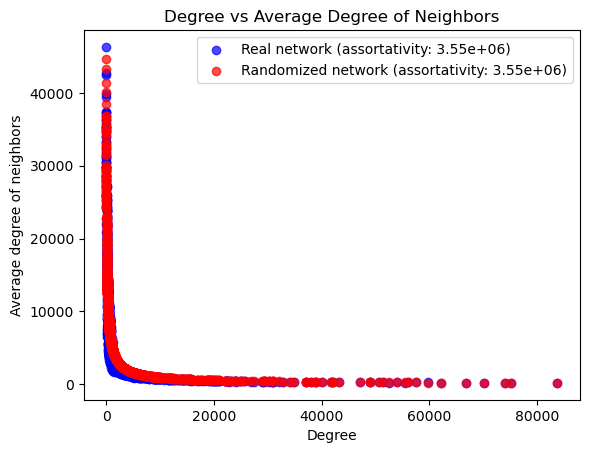

In [7]:
graph_tool_anylzer.plot_degree_vs_avg_degree("Degree vs Average Degree of Neighbors", plot_randomized=True)


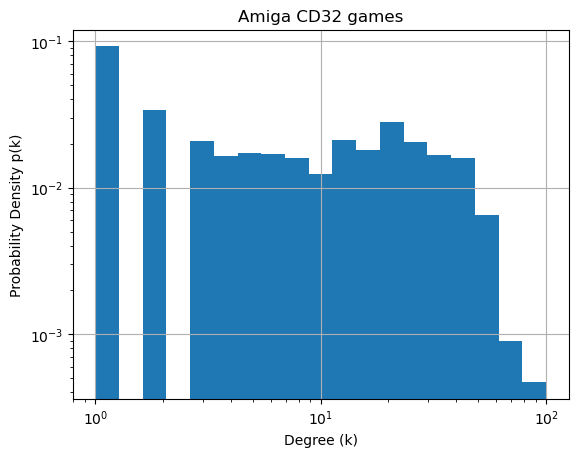

In [33]:
graph_tool_anylzer.plot_log_log_probability_density('Amiga CD32 games')


In [19]:
graph_tool_anylzer.plot_centralities()

AttributeError: 'GraphToolAnalyzer' object has no attribute 'calculate_centralities'

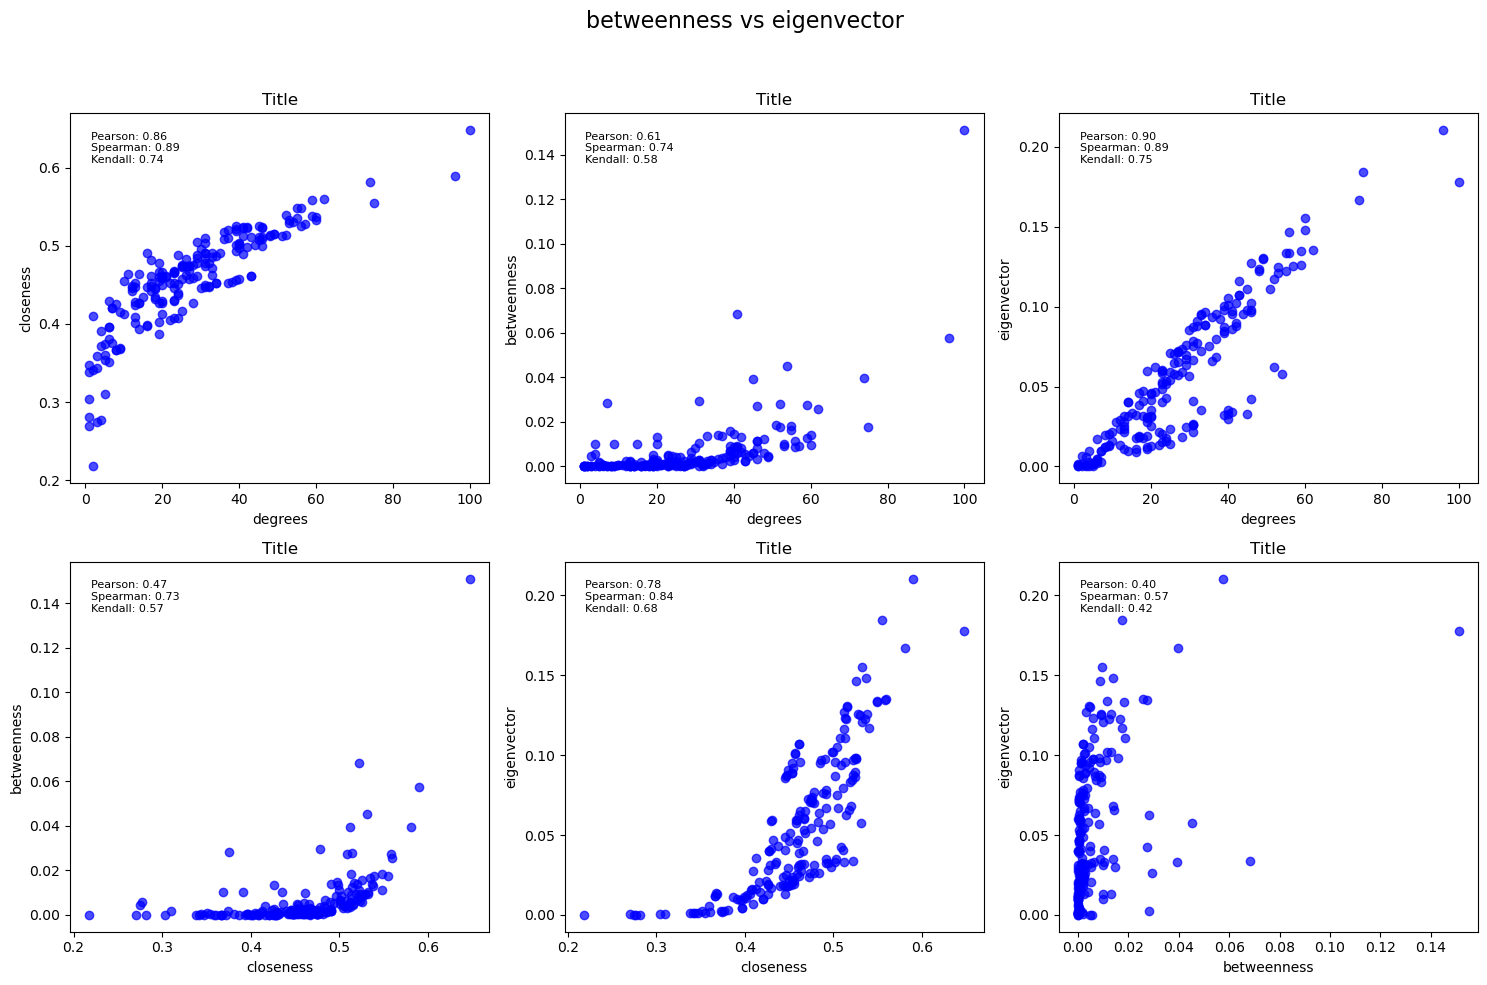

In [15]:
graph_tool_anylzer.plot_centralities_comparison()

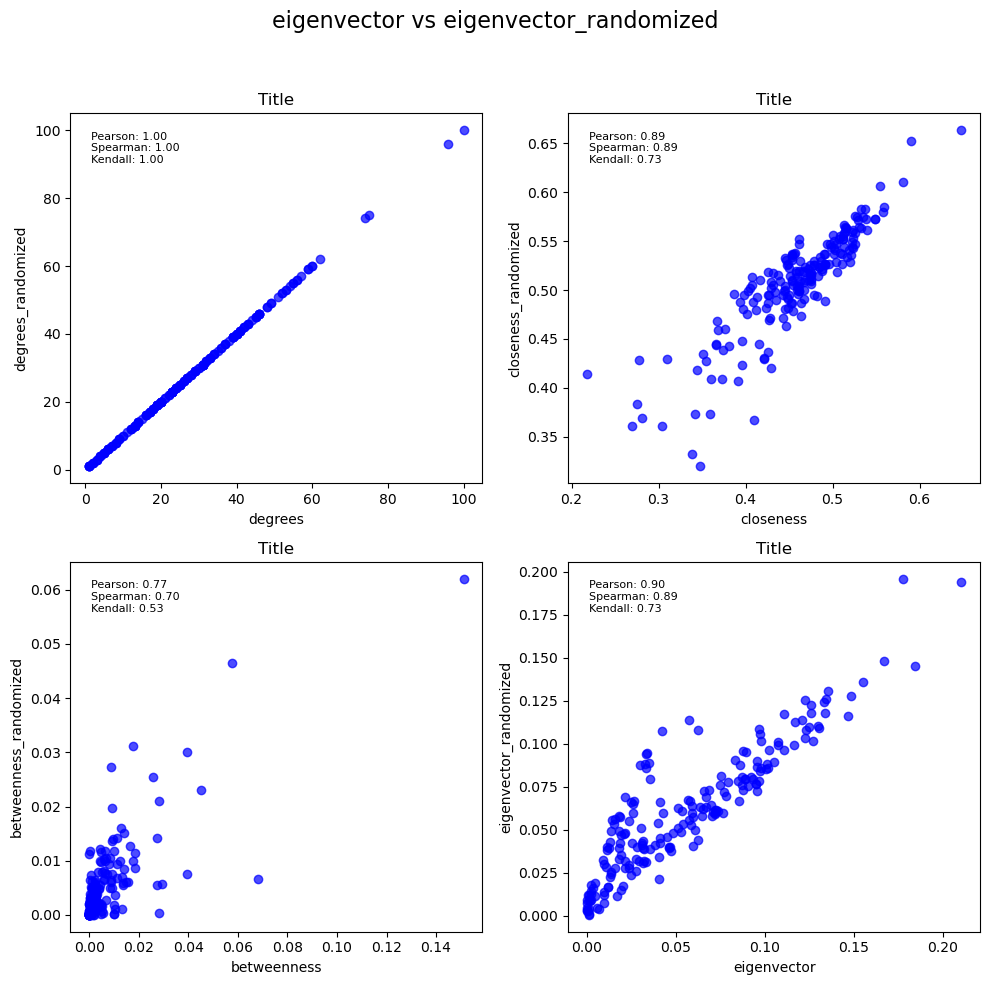

In [16]:
graph_tool_anylzer.plot_centralities_comparison_randomized()

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
import math
import networkx as nx


class GraphAnalyzer:
    def __init__(self, graph):
        self.graph = graph
        self.randomized_graph = None
        self.measures = ['degrees','closeness', 'betweenness', 'eigenvector']
        self.centrality = {}


    def get_degree_and_average_degree_of_neighbors(self, G=None):
        if G==None:
            G = self.graph
        degrees, average_degrees = [], []

        for node in G.nodes(data=True):
            neighbors = list(G.neighbors(node[0]))

            sum_degrees = 0

            for neighbor in neighbors:
                sum_degrees += G.degree(neighbor)

            current_node_degree = G.degree(node[0])
            if len(neighbors) == 0:
                average_degree = 0
            else:
                average_degree = sum_degrees / len(neighbors)
            degrees.append(current_node_degree)
            average_degrees.append(average_degree)

            degree_dict = defaultdict(lambda: {'sum': 0, 'count': 0})

            for degree, avg_degree in zip(degrees, average_degrees):
                degree_dict[degree]['sum'] += avg_degree
                degree_dict[degree]['count'] += 1

            unique_degrees = []
            averaged_average_degrees = []

            for degree, values in degree_dict.items():
                unique_degrees.append(degree)
                averaged_average_degrees.append(values['sum'] / values['count'])

        
        return unique_degrees, averaged_average_degrees

    def plot_degree_vs_avg_degree(self, title, plot_randomized=False):

        x,y = self.get_degree_and_average_degree_of_neighbors()
        assortativity_real_network = self.calculate_assortativity()

        color = 'blue'
        label_real_network = f'real network (assortativity: {float("{:.3g}".format(assortativity_real_network)) })'
        data = [(x, y, color, label_real_network)]

        if plot_randomized:
            self.randomize_graph()
            x,y = self.get_degree_and_average_degree_of_neighbors(self.randomized_graph)
            assortativity_randomized_network = self.calculate_assortativity(self.randomized_graph)

            color = 'red'
            label_randomized_network = f'randomized network (assortativity: {float("{:.3g}".format(assortativity_randomized_network)) })'
            data.append((x, y, color, label_randomized_network))

        fig, ax = plt.subplots()
        for data_set in data:
            x, y, color, label= data_set
            ax.scatter(x, y, c=color, label=label)
        
        ax.legend()
        plt.xlabel('Degree')
        plt.ylabel('Average degree of neighbors')
        plt.title(title)
        plt.show()

    def randomize_graph(self, force_randomization=False):
        if self.randomized_graph == None:
            self.randomized_graph = nx.algorithms.smallworld.random_reference(self.graph, n_iter=3, connectivity=False, seed=None)

    def calculate_assortativity(self, G=None):
        if G is None:
            G = self.graph
        return nx.degree_assortativity_coefficient(G)

    def plot_log_log_probability_density(self, title):

        G = self.graph
        degrees = [degree for node, degree in G.degree()]
        logarithmic_bins = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), num=20)

        plt.hist(degrees, bins=logarithmic_bins, density=True)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Degree (k)')
        plt.ylabel('Probability Density p(k)')
        plt.title(title)
        plt.show()

    def plot_log_log_centrality_distribution(self, centralities, logarithmic_bins, x_label='not defined', y_label='Probability Density'): 

        plt.hist(centralities, bins=logarithmic_bins, density=True)
        # plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title('Title')
        plt.show()

    def calculate_centralities(self, is_randomized=False):
        if is_randomized:
            G = self.randomized_graph
            suffix = '_randomized'

        else:
            G = self.graph
            suffix = ''

        self.centrality[f'degrees{suffix}'] = [d for n, d in G.degree()]
        self.centrality[f'closeness{suffix}'] = list(nx.closeness_centrality(G).values())
        self.centrality[f'betweenness{suffix}'] = list(nx.betweenness_centrality(G).values())
        self.centrality[f'eigenvector{suffix}'] = list(nx.eigenvector_centrality(G).values())

 

    def plot_centralities(self):
        self.calculate_centralities()

        for measure in self.measures:
            linear_bins = np.linspace(min(self.centrality[measure]), max(self.centrality[measure]), num=16)
            self.plot_log_log_centrality_distribution(self.centrality[measure], linear_bins, measure, 'TBD')

    def plot_centralities_comparison(self):

        self.calculate_centralities()

        measure_pairs = [(x, y) for x in self.measures for y in self.measures if x != y]
        for pair in measure_pairs:
            if (pair[1], pair[0]) in measure_pairs:
                measure_pairs.remove((pair[1], pair[0]))

        data_structure = []
        for measure_pair in measure_pairs:

            data_structure.append([(self.centrality[measure_pair[0]], self.centrality[measure_pair[1]], 'blue',
                                f"{measure_pair[0]} vs {measure_pair[1]}", measure_pair[0], measure_pair[1], 'Title')])

        self.plot_centrality_measure_vs_centrality_measure(
            data_structure, f"{measure_pair[0]} vs {measure_pair[1]}", show_legend=False)
    

  
    def plot_centrality_measure_vs_centrality_measure(self, data, overall_title, show_legend=True):
        n_plots = len(data)

        n_cols = min(3, math.ceil(math.sqrt(n_plots)))  
        n_rows = math.ceil(n_plots / n_cols)

        fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

        if n_rows == 1 and n_cols == 1:
            ax = [ax]
        else:
            ax = ax.flatten()

        for i in range(n_plots):
            corr_text = ""
            for data_point in data[i]:
                x, y, color, label, x_label, y_label, title = data_point
                pearson_corr, _ = pearsonr(x, y)
                spearman_corr, _ = spearmanr(x, y)
                kendall_corr, _ = kendalltau(x, y)
                corr_text += (
                    f"Pearson: {pearson_corr:.2f}\n"
                    f"Spearman: {spearman_corr:.2f}\n"
                    f"Kendall: {kendall_corr:.2f}"
                )
                ax[i].scatter(x, y, c=color, label=label, alpha=0.7)

            ax[i].text(0.05, 0.95, corr_text, transform=ax[i].transAxes,
                    fontsize=8, verticalalignment='top')
            if show_legend:
                ax[i].legend()
            ax[i].set_xlabel(x_label)
            ax[i].set_ylabel(y_label)
            ax[i].set_title(title)

        for j in range(n_plots, len(ax)):
            fig.delaxes(ax[j])

        fig.suptitle(overall_title, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    def plot_centralities_comparison_randomized(self):
        self.randomize_graph()
        self.calculate_centralities()
        self.calculate_centralities(True)


        measure_pairs_randomized = []
        for i in range(len(self.measures)):
            measure_pairs_randomized.append((self.measures[i], self.measures[i] + '_randomized'))
        data_structure = []

        for measure_pair in measure_pairs_randomized:
            data_structure.append([(self.centrality[measure_pair[0]], self.centrality[measure_pair[1]], 'blue',
                                    f"{measure_pair[0]} vs {measure_pair[1]}", measure_pair[0], measure_pair[1], 'Title')])
        self.plot_centrality_measure_vs_centrality_measure(
                data_structure, f"{measure_pair[0]} vs {measure_pair[1]}", show_legend=False)

ModuleNotFoundError: No module named 'networkx'

In [ ]:
graph_analyzer = GraphAnalyzer(G)
